# 🛵 Food Delivery Time Prediction
Predicting whether delivery will be 'Fast' or 'Delayed'.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [3]:
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [4]:
print(df.isnull().sum())
df.fillna(df.median(numeric_only=True), inplace=True)


Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [5]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df[['Cust_lat', 'Cust_long']] = df['Customer_Location'].str.strip('()').str.split(',', expand=True).astype(float)
df[['Rest_lat', 'Rest_long']] = df['Restaurant_Location'].str.strip('()').str.split(',', expand=True).astype(float)
df['Geo_Distance'] = df.apply(lambda row: haversine(row['Cust_lat'], row['Cust_long'], row['Rest_lat'], row['Rest_long']), axis=1)


In [6]:
label_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])


In [7]:
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > 45 else 0)


In [8]:
scaler = StandardScaler()
features = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating',
            'Customer_Rating', 'Delivery_Time', 'Order_Cost', 'Tip_Amount', 'Geo_Distance']
df[features] = scaler.fit_transform(df[features])


In [9]:
X = df.drop(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Delivery_Status'], axis=1)
y = df['Delivery_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 1.0
[[10  0]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        30

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [11]:
param_grid = {'n_neighbors': range(3, 20)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)
knn = grid.best_estimator_
y_pred_knn = knn.predict(X_test)

print("KNN Best K:", grid.best_params_)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN Best K: {'n_neighbors': 5}
KNN Accuracy: 0.725
[[ 1  9]
 [ 2 28]]
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.76      0.93      0.84        30

    accuracy                           0.72        40
   macro avg       0.55      0.52      0.49        40
weighted avg       0.65      0.72      0.67        40



In [12]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 1.0
[[10  0]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        30

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



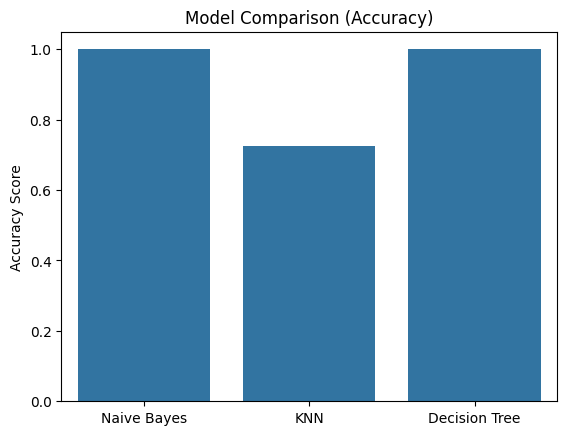

In [13]:
models = ['Naive Bayes', 'KNN', 'Decision Tree']
scores = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_dt)]

sns.barplot(x=models, y=scores)
plt.title("Model Comparison (Accuracy)")
plt.ylabel("Accuracy Score")
plt.show()


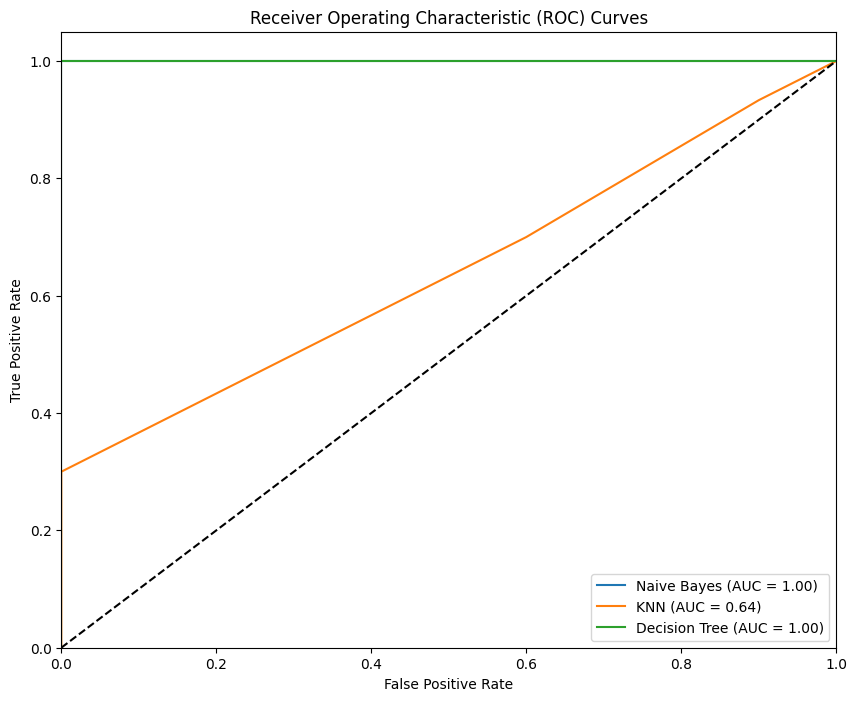

In [15]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Naive Bayes ROC
nb_probs = nb.predict_proba(X_test)[:, 1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
nb_auc = auc(nb_fpr, nb_tpr)
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')

# KNN ROC
knn_probs = knn.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_auc = auc(knn_fpr, knn_tpr)
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')

# Decision Tree ROC
dt_probs = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
dt_auc = auc(dt_fpr, dt_tpr)
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
